<a href="https://colab.research.google.com/github/Shirui-peng/Deep-Learning-in-Quantitative-Trading/blob/main/Chapter2/02_ts_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autoregressive (AR), Moving Average (MA), and Autoregressive Moving Average (ARMA) models. Our aim is to provide an intuitive and practical overview of these classical approaches rather than to rigorously compare their performance out of sample. To illustrate these models in action, we will simulate some return data and highlight how AR, MA, and ARMA models capture and explain time-dependent structure in financial data. By the end of this notebook, you should have a clear understanding of how to implement these models and interpret their outputs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf

In [2]:
ret = np.random.normal(0,1, 1000)

df = pd.DataFrame(ret, columns=['return'])

## AR(p)

In order to choose the p of a AR process, we look at the PACF plot. We look for a sharp cutoff after p lags (i.e., significant partial autocorrelations up to lag p, then close to zero after that).

## MA(q)

For a MA process with q order, we look at the ACF plot. If you see a clear cutoff after lag q, that suggests an MA(q) process.

## ARMA(p,q)

We look at both PACF and ACF plots. A partial cutoff in the ACF (not purely a single step, but a few significant lags) might indicate an MA component. A partial cutoff in the PACF might indicate an AR component.

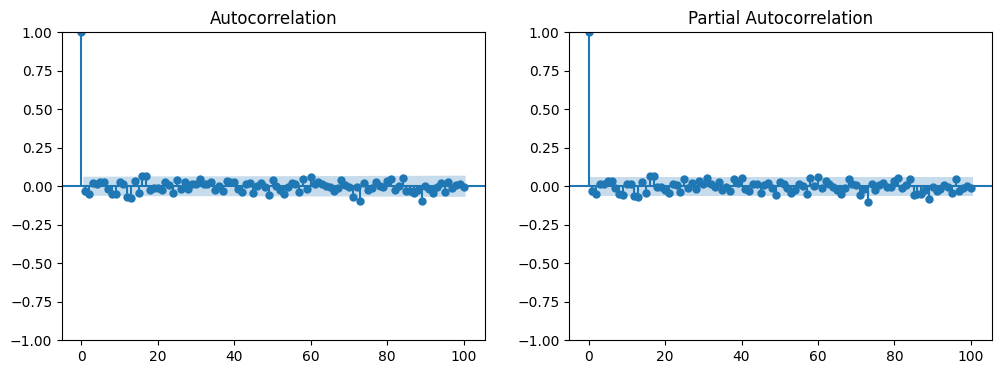

In [3]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(df['return'], lags=100, ax=ax[0])   # ACF
plot_pacf(df['return'], lags=100, ax=ax[1]) # PACF
plt.show()

In [4]:
def get_AR(data, p, test_data):
  arma_model = ARIMA(data, order=(p, 0, 0))
  arma_result = arma_model.fit()
  predictions = arma_result.predict(start=test_data.index[0], end=test_data.index[-1])
  return arma_result, predictions

def get_MA(data, q, test_data):
  arma_model = ARIMA(data, order=(0, 0, q))
  arma_result = arma_model.fit()
  predictions = arma_result.predict(start=test_data.index[0], end=test_data.index[-1])
  return arma_result, predictions

def get_ARMA(data, p, q, test_data):
  arma_model = ARIMA(data, order=(p, 0, q))
  arma_result = arma_model.fit()
  predictions = arma_result.predict(start=test_data.index[0], end=test_data.index[-1])
  return arma_result, predictions

In [5]:
train_size = int(len(df)*0.9)
train_data = df['return'].iloc[:train_size]
test_data  = df['return'].iloc[train_size:]

model_ar, pred_ar = get_AR(train_data, p=2, test_data=test_data)
model_ma, pred_ma = get_MA(train_data, q=2, test_data=test_data)
model_arma, pred_arma = get_ARMA(train_data, p=2, q=3, test_data=test_data)

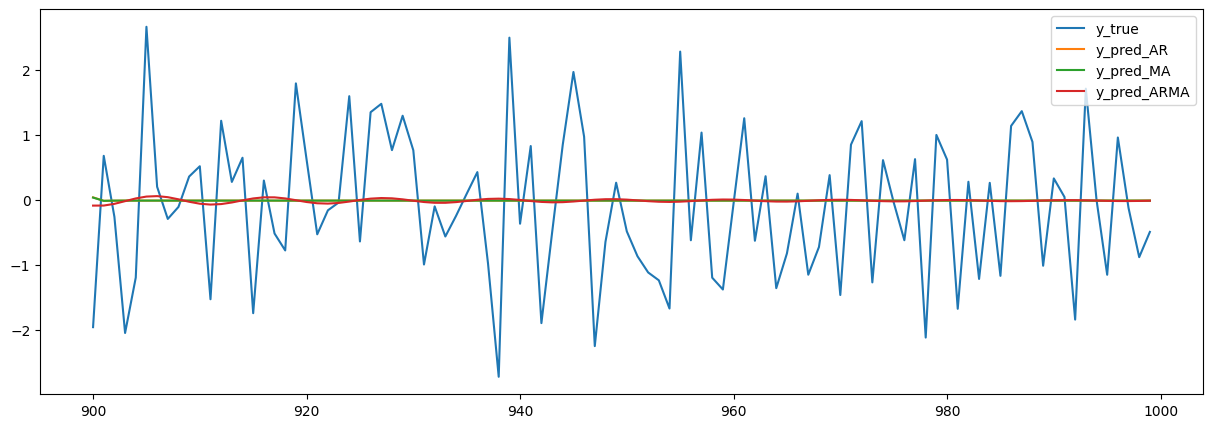

In [6]:
plt.figure(figsize=(15,5))
plt.plot(test_data, label='y_true')
plt.plot(pred_ar, label='y_pred_AR')
plt.plot(pred_ma, label='y_pred_MA')
plt.plot(pred_arma, label='y_pred_ARMA')
plt.legend()


## AR(2) Process

The following time series is an AR(2) process with 128 timesteps and the following parameters:

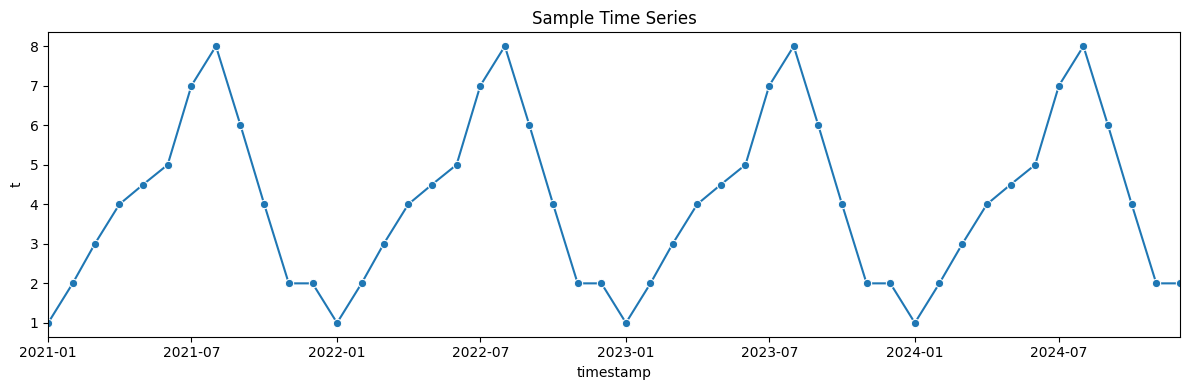

In [12]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

T = 12

sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=48, freq='MS'),
                       't' : [1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2, 1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2, 1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2, 1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2]
                      })

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

In [13]:
check_stationarity(sample['t'])

ADF Statistic: -24886124212233.375000
p-value: 0.000000
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
Stationary


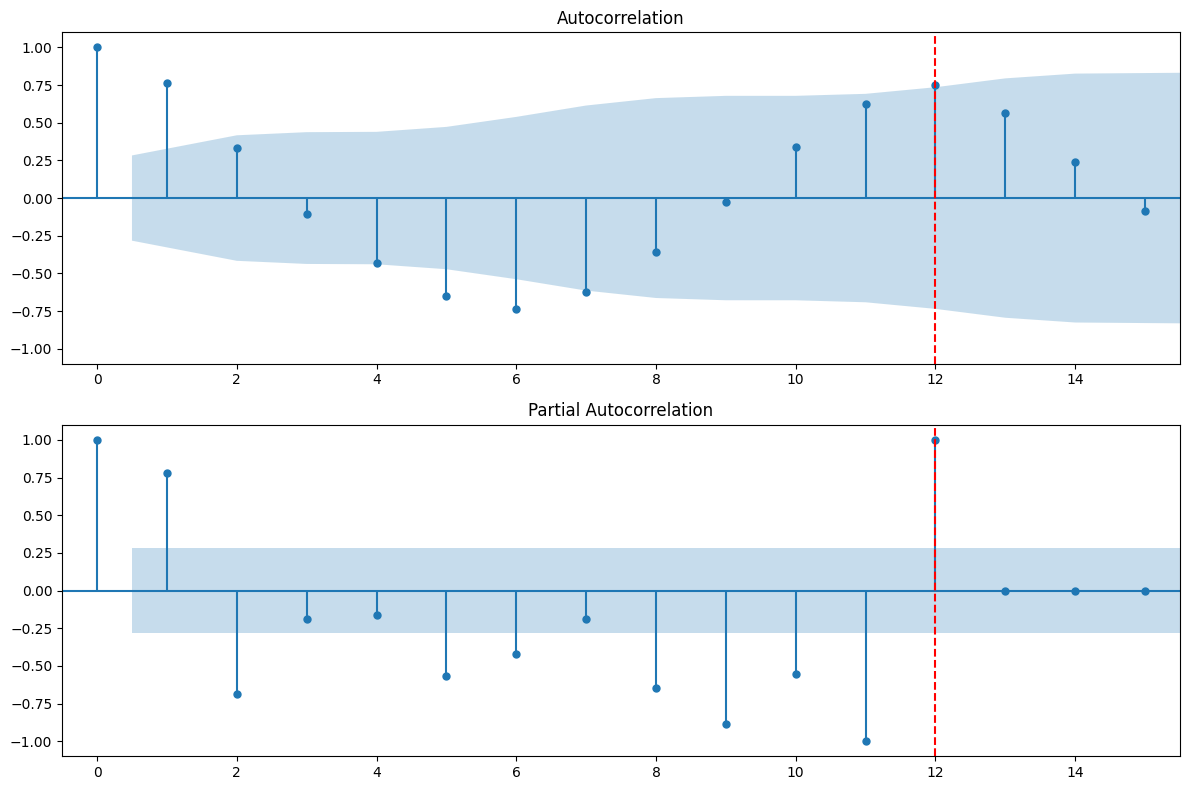

In [15]:
# Visualizations
lag_acf = 15
lag_pacf = 15
height = 4
width = 12

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(sample['t'],lags=lag_acf, ax=ax[0])
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[1], method='ols')

for i in range(2):
    ax[i].axvline(x=T, color='r', linestyle='--')
    ax[i].set_xlim([-0.5, lag_acf+0.5])
    ax[i].set_ylim([-1.1, 1.1])

plt.tight_layout()
plt.show()

In [16]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA

train = sample['t'][:26]
ar_model = AutoReg(train, lags=12).fit()

print(ar_model.summary())
pred = ar_model.predict(start=26, end=48, dynamic=False)

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                   26
Model:                    AutoReg(12)   Log Likelihood                 434.691
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Thu, 11 Sep 2025   AIC                           -841.383
Time:                        19:58:29   BIC                           -832.436
Sample:                            12   HQIC                          -842.211
                                   26                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0205   7.86e-18   2.61e+15      0.000       0.021       0.021
t.L1          -0.0004   4.89e-15  -8.64e+10      0.000      -0.000      -0.000
t.L2          -0.0004   5.02e-15  -8.43e+10      0.0

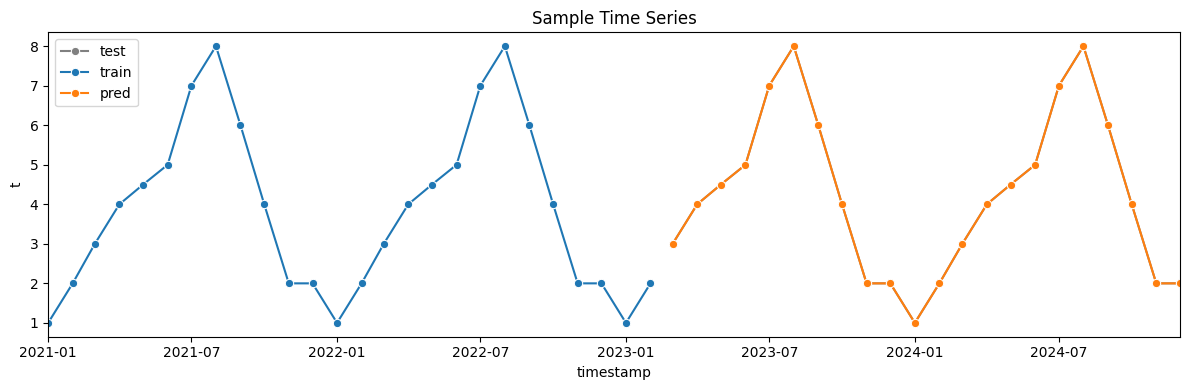

In [17]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=sample.timestamp[26:48], y=sample.t[26:48], marker='o', label='test', color='grey')
sns.lineplot(x=sample.timestamp[:26], y=train, marker='o', label='train')
sns.lineplot(x=sample.timestamp[26:48], y=pred, marker='o', label='pred')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

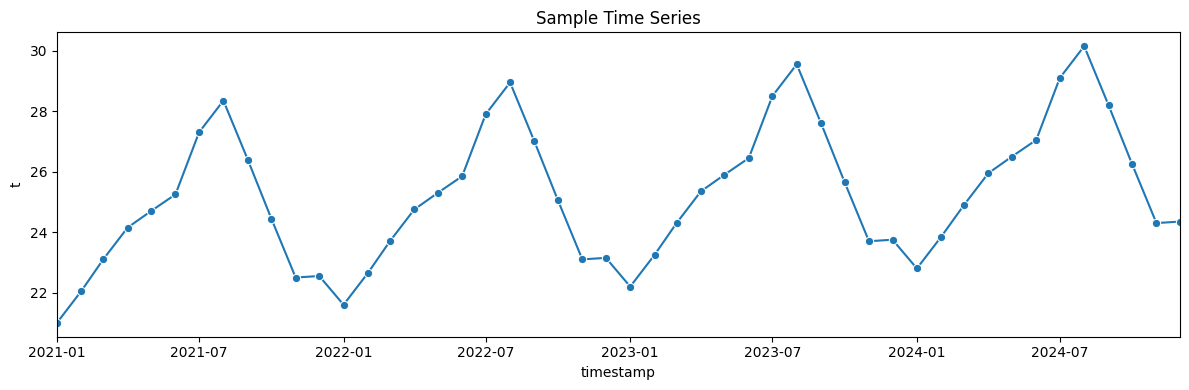

In [18]:
time = np.arange(0, 48)
sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=48, freq='MS'),
                       't' : [1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2, 1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2, 1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2, 1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2] + ((0.05*time)+20)
                      })

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

In [19]:
check_stationarity(sample['t'])

ADF Statistic: -0.117684
p-value: 0.947648
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
Non-stationary


In [20]:
sample['t_diff'] = sample['t'].diff().fillna(0)

display(sample.head(5).style.set_caption('Sample Time Series'))

check_stationarity(sample['t_diff'])

,timestamp,t,t_diff
0,2021-01-01 00:00:00,21.000000,0.000000
1,2021-02-01 00:00:00,22.050000,1.050000
2,2021-03-01 00:00:00,23.100000,1.050000
3,2021-04-01 00:00:00,24.150000,1.050000
4,2021-05-01 00:00:00,24.700000,0.550000


ADF Statistic: -21.691240
p-value: 0.000000
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
Stationary


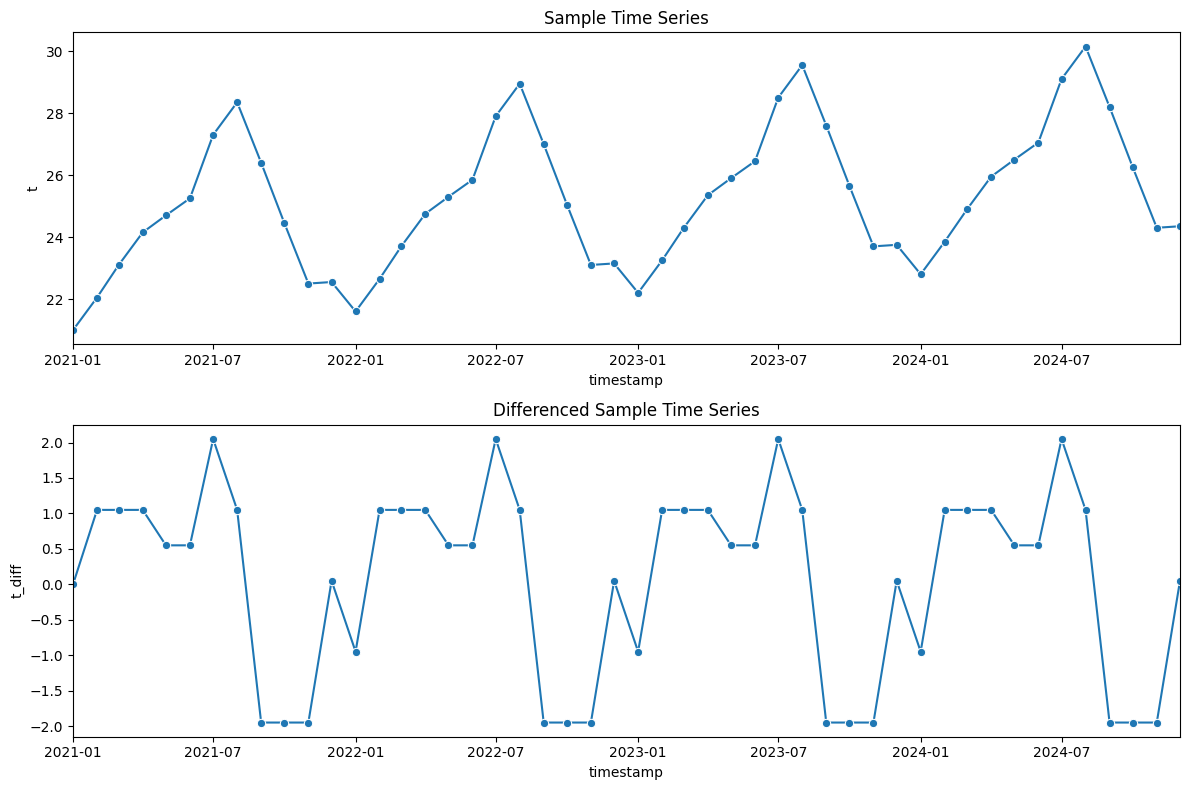

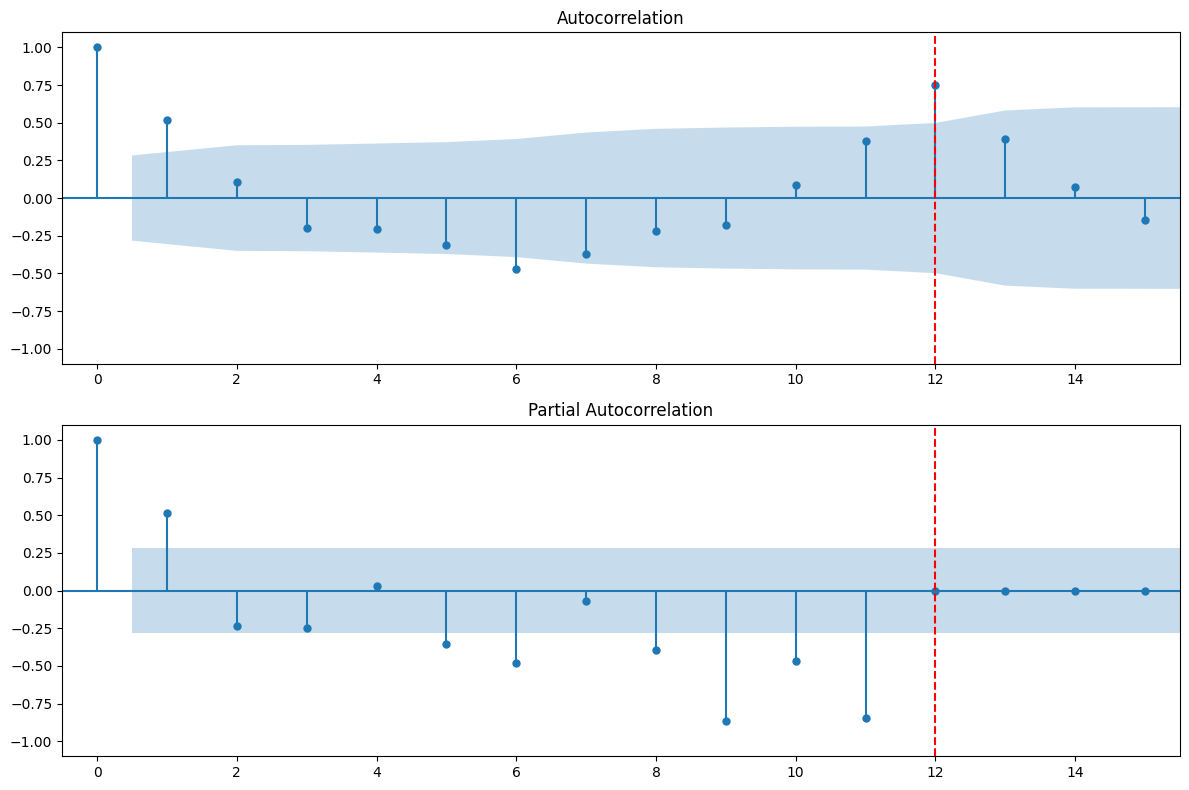

In [21]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o', ax=ax[0])
ax[0].set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])

ax[0].set_title('Sample Time Series')

sns.lineplot(x=sample.timestamp, y=sample['t_diff'], marker='o', ax=ax[1])
ax[1].set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax[1].set_title('Differenced Sample Time Series')
plt.tight_layout()
plt.show()

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(sample['t_diff'],lags=lag_acf, ax=ax[0])
plot_pacf(sample['t_diff'],lags=lag_pacf, ax=ax[1], method='ols')

for i in range(2):
    ax[i].axvline(x=T, color='r', linestyle='--')
    ax[i].set_xlim([-0.5, lag_acf+0.5])
    ax[i].set_ylim([-1.1, 1.1])

plt.tight_layout()
plt.show()